# 3) Topic modelling
In this section, I will try to give a more robust answer to the question **"What are the most common topics discussed in stand-up comedy?"**. To do this, I will use 3 different techniques to investigate deeper into the hints provided from the EDA:

   - 3.1) I will use statistical Named-Entity-Recognition (NER) from the `en_core_web_md` language model of the `SpaCy` library to further investigate the content of the scripts identifying the most common public figures, geographical areas, nationalities, religious or political groups discussed across all stand-up shows.
   - 3.2) I will employ Latent Dirichlet Allocation (LDA) on the term frequency matrix (built using the bag-of-words method) to extract latent topics and assess their relevance across the 143 stand-up comedy scripts.
   - 3.3) After vectorizing texts and building a term frequency–inverse document frequency (tf-IDF) matrix, I will reduce the features' dimensionality with principal component analysis (PCA) and I will fine-tune a k-means algorithm using the elbow method to identify the optimal number of `k` clusters of topics.
   
The outcomes of NER, LDA and k-means models are in line with the hints retrieved from the EDA. Anecdotes about personal experiences, daily-life situations and family are by far the most common topic in stand-up comedy. However, the extent of this topic category and its diversity in terms of stories/characters involved makes the data very noisy and it is therefore not possible to breakdown this class in a small number of neat and defined topics. Furthermore, the fact that most comedians tackle a mix of topics in each show (from personal stories, to politics and sex) complicates this distinction even more.

The analysis carried out in this section also finds confirmation of the fact that both satire on politicians, national & religious groups and on sex/relationships are popular topics discussed in stand-up routines. Interestingly, scripts that deal with the former type of comedy are those that distinguish themself more easily compared to the rest of the scripts in the sample. This happens probably because most of the comedians specialised on these type of topic tend to discuss them more consistenly throughout the entire show.

## 3.1) Named Entity Recognition (NER)
Named-entity recognition (NER) is the task of identifying and categorizing key information (entities) in text. An entity can be any real-world object, such as persons, locations, organizations, products, etc., that can be denoted with a proper name.

Here I will use the Named Entity Recognizer model of the [SpaCy medium language model](https://github.com/explosion/spacy-models/releases//tag/en_core_web_md-3.0.0) to parse the stand-up scripts and extract named entities. This pre-trained NER model has been trained on texts like blog articles, news, comments. It comes with a precision of 0.86 (ENTS_P), a recall (ENTS_R) and a F-score (ENTS_F) of 0.85 respectively.

The steps are:
- 1) parsing documents using the NER model of the spaCy language model and store all the results in a dataframe;
- 2) analysing frequency of the entities found in corpus and intepret the results.

The insights obtained from the NER model are:

- The NER model finds a total number of 10517 unique named entities across the whole document corpus. The most common entity category mentioned in stand-up shows are: people (PERSON); cardinal numbers (CARDINAL); dates (DATE); geopolitical entities (GPE) like countries, cities, states; nationalities, religious and political groups (NORP); Organizations (ORG). Considering the type of text under analysis, PERSON, GPE, NORP and ORG constitute the most interesting categories to investigate in more detail.

- Notice also that the NER model doesn't have bullet-proof accuracy and mistakenly considers some tokens as named entities (e.g., "yo", "bitch", "Y'all", "Uhhuhu") or misclassifies them (e.g., Facebook is considered a PERSON instead of as an ORG and the opposite happens for O.J. Simpson).

- The fact that PERSON is the most common named-entity category by far (3688 unique entities and over 11000 mentions) confirms the hypotheses made at EDA stage. Among the most mentioned PERSON entities there are common names (e.g., dad), politicians (e.g., Donald Trump, Barack, Hitler, Bill Clinton), celebrities (e.g., Michael Jackson) and many other proper names. What also emerges from the NER analysis is that the average number of mentions for each unique PERSON entity is actually quite low (around 3.19 mentions per entity) compared to those of named-entities from other categories like NORP and GPE. This means that the diversity of stories and characters is very high and therefore topic extraction/summarization tecniques (especially those based on token-frequency only) might encounter some difficulties in defining neat and well-defined topics.    

- References to English-speaking countries/states/cities (e.g., America, Canada, United States, California, LA, New York, India) constitute the majority of the geographic/geopolitical entities (GPE) mentioned in stadn-up comedy confirming also in this case the intial insights obtained from the EDA. 

- In terms of nationalities/political groups (NORP), Americans, Indian, Asian, Chinese, Mexican as well as European nationalities are among the most popular groups mentioned in stand-up comedy.

- With respect to organizations (ORG), references to terrorist organizations (i.e., ISIS), video services(e.g., Youtube, Neflix), social media (e.g., Instagram, Pinterest, WhatsApp) and popular consumer brands (e.g., McDonalds, Disney, Starbucks, Ferrari) are among the most commonly mentioned.

- Finally, NER also confirms that no sizeable differences exists among male and female commedians in terms of entities mentioned.

In [ ]:
# Imported libraries 
from tqdm import tqdm
import os
import re
import string
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import spacy
import itertools
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

In [25]:
# Load spaCy medium English language model (it has higher precision compared to the en_small model)
nlp_NER = spacy.load("en_core_web_md", disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])

# Show pipeline
NER_medium_model = nlp_NER.analyze_pipes(pretty=True)


============================= Pipeline Overview =============================

#   Component   Assigns          Requires   Scores          Retokenizes
-   ---------   --------------   --------   -------------   -----------
0   ner         doc.ents                    ents_f          False      
                token.ent_iob               ents_p                     
                token.ent_type              ents_r                     
                                            ents_per_type              

✔ No problems found.


In [26]:
## Apply NER model to find entities

ents_text = [] # Entity found in text
ents_label = [] # Entity type
ents_id = [] # Document ID
ents_desc = [] # Description of the entity type

for text, doc_num in tqdm(zip(doc_list, range(0, len(doc_list)))):
    
    # Keep track of the doc ID for each extracted entity 
    doc = nlp_NER(text)
    ents_id.append([doc_num]*len(doc.ents))
    
    # Extract named entity, entity type and description 
    for ent in doc.ents:
        ents_text.append(ent.text)
        ents_label.append(ent.label_)
        ents_desc.append(str(spacy.explain(ent.label_)))
        

# Join all the output in a dataframe
ent_id_unique = list(itertools.chain(*ents_id))
entities = pd.DataFrame(list(zip(ent_id_unique, ents_text, ents_label, ents_desc)), columns =['Doc_id', 'Entity', 'Ent_label', 'Ent_desc']) 
entities.head()

143it [01:36,  1.48it/s]


,Doc_id,Entity,Ent_label,Ent_desc
0,0,Adam Devine,PERSON,"People, including fictional"
1,0,tonight,TIME,Times smaller than a day
2,0,today,DATE,Absolute or relative dates or periods
3,0,Ham,PERSON,"People, including fictional"
4,0,two months,DATE,Absolute or relative dates or periods


In [27]:
## Correct some entities values
entities['Entity'].replace('Trump', 'Donald Trump', inplace=True)
entities = entities[entities['Entity'] != 'Shit']

#### Entities mentioned by type

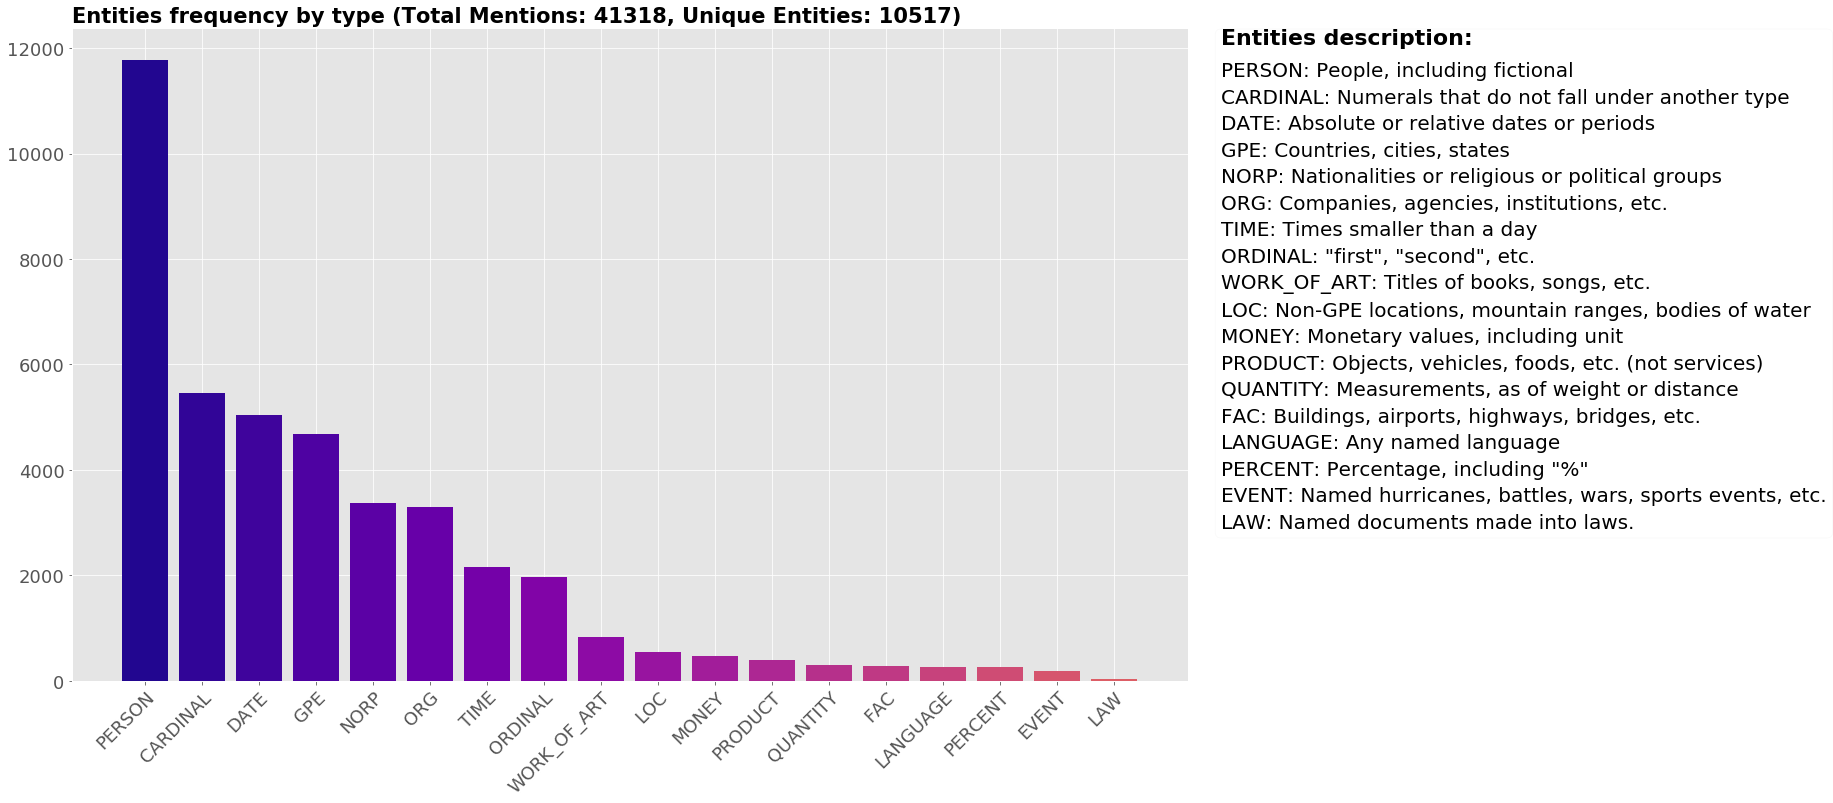

In [28]:
## Bar chart - Entities frequency by type

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 18 # set default font size

fig, ax = plt.subplots(1, 1, figsize=(20, 12))#set subplot and fig size

# Define numbers, labels and text box with data description
ent_group = entities.groupby(['Ent_label', 'Ent_desc'])['Ent_label'].agg(['count']).reset_index().sort_values('count', ascending=False)
ent_num = ent_group['count']
ent_lbl = ent_group['Ent_label']
ent_desc = ent_group[['Ent_label', 'Ent_desc']].agg(': '.join, axis=1)

# Chart
ax.bar(ent_lbl, ent_num, color=sns.color_palette("plasma", 30))
ax.set_title('Entities frequency by type (Total Mentions: {}, Unique Entities: {})'
             .format(len(entities), entities['Entity'].nunique()), fontweight='bold', fontsize=21, loc='left')

plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

props = dict(boxstyle='round', facecolor='white', alpha=0.5) # Matplotlib.patch.Patch properties
textstr = '\n'.join(ent_desc) # Join in a unique piece of text
ax.text(1.03, 0.99, '\n'+textstr, transform=ax.transAxes, fontsize=20, verticalalignment='top', bbox=props, linespacing=1.5)
ax.text(1.03, 1.00, 'Entities description:', transform=ax.transAxes, fontsize=22, fontweight='bold', verticalalignment='top')

plt.show()

In [29]:
# Number of unique entities per category
print('Number of unique PERSON entities: ', entities[entities['Ent_label']=='PERSON']['Entity'].nunique())
print('\n', 'Number of unique GPE entities: ', entities[entities['Ent_label']=='GPE']['Entity'].nunique())
print('\n', 'Number of unique NORP entities: ', entities[entities['Ent_label']=='NORP']['Entity'].nunique())
print('\n', 'Number of unique ORG entities: ', entities[entities['Ent_label']=='ORG']['Entity'].nunique())

# Average number of mentions per entity in the corpus
print('\n\n', 'Average number of mentions per PERSON entity: ', list(ent_group[ent_group['Ent_label']=='PERSON']['count'].values/entities[entities['Ent_label']=='PERSON']['Entity'].nunique()))
print('\n', 'Average number of mentions per GPE entity: ', list(ent_group[ent_group['Ent_label']=='GPE']['count'].values/entities[entities['Ent_label']=='GPE']['Entity'].nunique()))
print('\n', 'Average number of mentions per NORP entity: ', list(ent_group[ent_group['Ent_label']=='NORP']['count'].values/entities[entities['Ent_label']=='NORP']['Entity'].nunique()))
print('\n', 'Average number of mentions per ORG entity: ', list(ent_group[ent_group['Ent_label']=='ORG']['count'].values/entities[entities['Ent_label']=='ORG']['Entity'].nunique()))

Number of unique PERSON entities:  3688

 Number of unique GPE entities:  796

 Number of unique NORP entities:  380

 Number of unique ORG entities:  1583


 Average number of mentions per PERSON entity:  [3.195227765726681]

 Average number of mentions per GPE entity:  [5.886934673366834]

 Average number of mentions per NORP entity:  [8.860526315789473]

 Average number of mentions per ORG entity:  [2.07706885660139]


#### Most mentioned entities

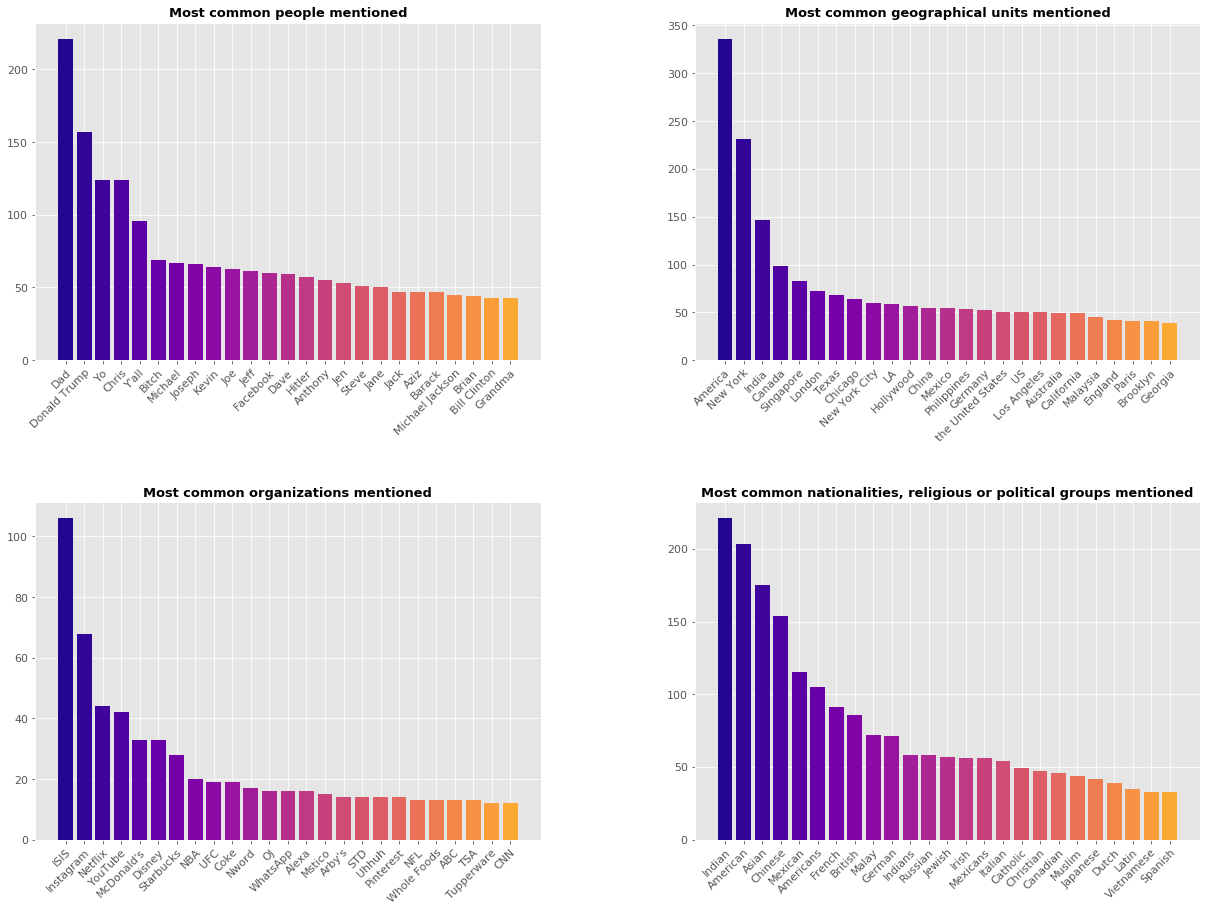

In [30]:
## Bar charts - Most cited entities (top 25)

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))#set subplot and fig size
fig.tight_layout(pad=11.0)


# AX1 PERSON
person_num = entities[entities['Ent_label']=='PERSON']['Entity'].value_counts().head(25)
person_lbl = entities[entities['Ent_label']=='PERSON']['Entity'].value_counts().head(25).index

ax[0,0].bar(person_lbl, person_num, color=sns.color_palette("plasma", 30))
ax[0,0].set_title('Most common people mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[0,0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX2 GPE

GPE_num = entities[entities['Ent_label']=='GPE']['Entity'].value_counts().head(25)
GPE_lbl = entities[entities['Ent_label']=='GPE']['Entity'].value_counts().head(25).index

ax[0,1].bar(GPE_lbl, GPE_num, color=sns.color_palette("plasma", 30))
ax[0,1].set_title('Most common geographical units mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[0,1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX3 ORG

ORG_num = entities[entities['Ent_label']=='ORG']['Entity'].value_counts().head(25)
ORG_lbl = entities[entities['Ent_label']=='ORG']['Entity'].value_counts().head(25).index

ax[1,0].bar(ORG_lbl, ORG_num, color=sns.color_palette("plasma", 30))
ax[1,0].set_title('Most common organizations mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[1,0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX4 NORP

NORP_num = entities[entities['Ent_label']=='NORP']['Entity'].value_counts().head(25)
NORP_lbl = entities[entities['Ent_label']=='NORP']['Entity'].value_counts().head(25).index

ax[1,1].bar(NORP_lbl, NORP_num, color=sns.color_palette("plasma", 30))
ax[1,1].set_title('Most common nationalities, religious or political groups mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[1,1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


plt.show()

In [31]:
# Select indeces for male/female comedians
male_coms = list(df[df['Gender']=='M'].index)
fem_coms = list(df[df['Gender']=='F'].index)

#### Most mentioned entities by male comedians

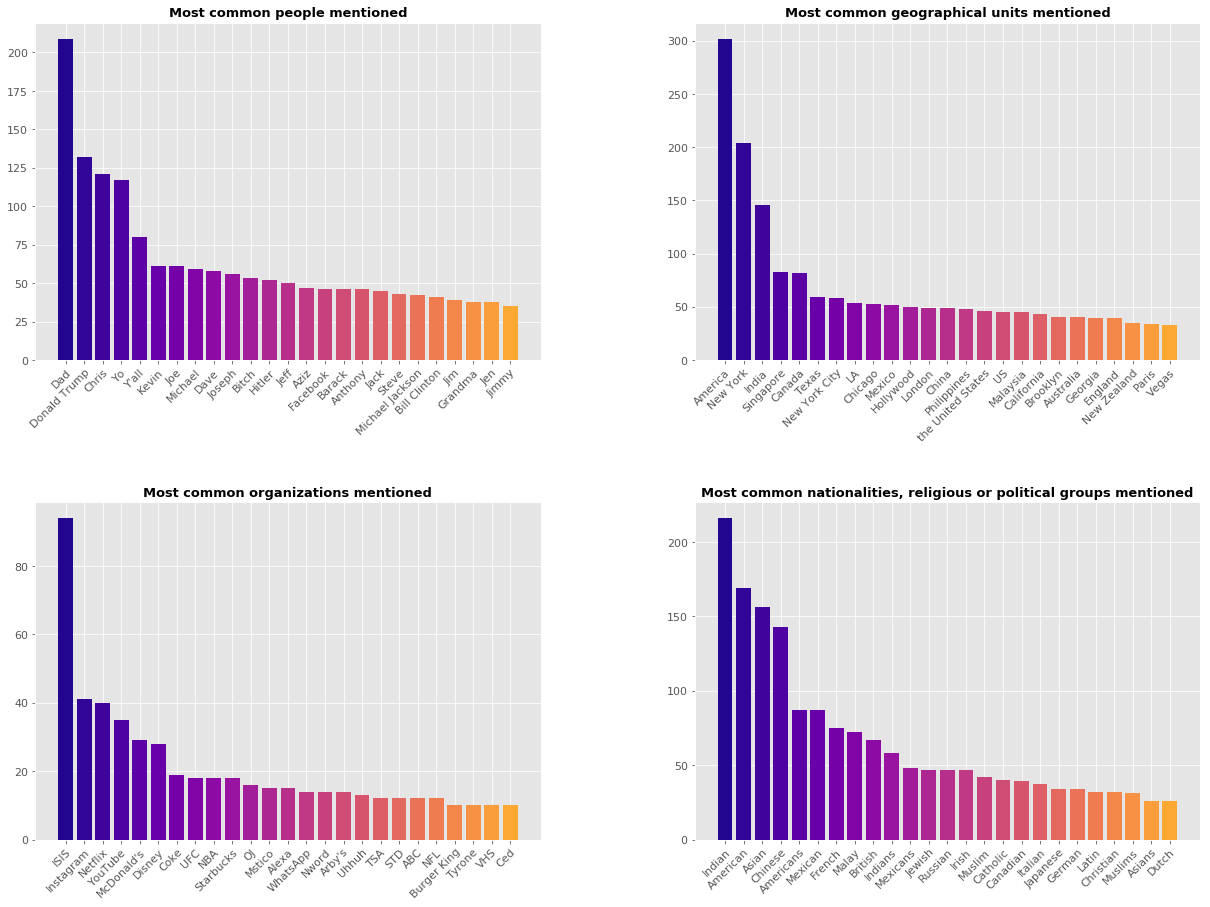

In [32]:
## Bar charts - Most cited entities (top 25) by MALE comedians

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))#set subplot and fig size
fig.tight_layout(pad=11.0)


# AX1 PERSON
person_num = entities[(entities['Ent_label']=='PERSON') & (entities['Doc_id'].isin(male_coms))]['Entity'].value_counts().head(25)
person_lbl = entities[(entities['Ent_label']=='PERSON') & (entities['Doc_id'].isin(male_coms))]['Entity'].value_counts().head(25).index

ax[0,0].bar(person_lbl, person_num, color=sns.color_palette("plasma", 30))
ax[0,0].set_title('Most common people mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[0,0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX2 GPE

GPE_num = entities[(entities['Ent_label']=='GPE') & (entities['Doc_id'].isin(male_coms))]['Entity'].value_counts().head(25)
GPE_lbl = entities[(entities['Ent_label']=='GPE') & (entities['Doc_id'].isin(male_coms))]['Entity'].value_counts().head(25).index

ax[0,1].bar(GPE_lbl, GPE_num, color=sns.color_palette("plasma", 30))
ax[0,1].set_title('Most common geographical units mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[0,1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX3 ORG

ORG_num = entities[(entities['Ent_label']=='ORG') & (entities['Doc_id'].isin(male_coms))]['Entity'].value_counts().head(25)
ORG_lbl = entities[(entities['Ent_label']=='ORG') & (entities['Doc_id'].isin(male_coms))]['Entity'].value_counts().head(25).index

ax[1,0].bar(ORG_lbl, ORG_num, color=sns.color_palette("plasma", 30))
ax[1,0].set_title('Most common organizations mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[1,0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX4 NORP

NORP_num = entities[(entities['Ent_label']=='NORP') & (entities['Doc_id'].isin(male_coms))]['Entity'].value_counts().head(25)
NORP_lbl = entities[(entities['Ent_label']=='NORP') & (entities['Doc_id'].isin(male_coms))]['Entity'].value_counts().head(25).index

ax[1,1].bar(NORP_lbl, NORP_num, color=sns.color_palette("plasma", 30))
ax[1,1].set_title('Most common nationalities, religious or political groups mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[1,1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


plt.show()

#### Most mentioned entities by female comedians

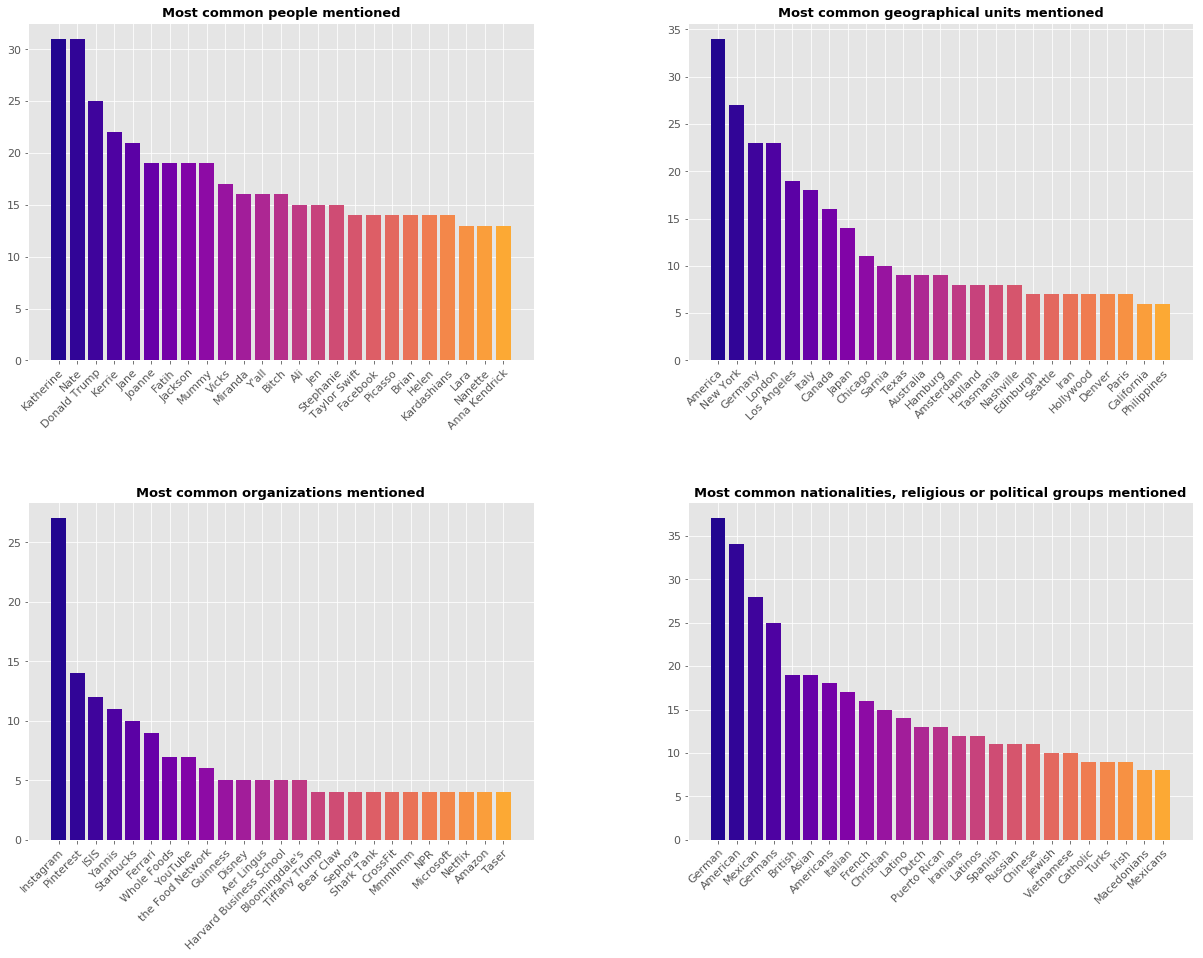

In [33]:
## Bar charts - Most cited entities (top 25) by FEMALE comedians

plt.style.use('ggplot')#set style
plt.rcParams["font.size"] = 11 # set default font size

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))#set subplot and fig size
fig.tight_layout(pad=11.0)


# AX1 PERSON
person_num = entities[(entities['Ent_label']=='PERSON') & (entities['Doc_id'].isin(fem_coms))]['Entity'].value_counts().head(25)
person_lbl = entities[(entities['Ent_label']=='PERSON') & (entities['Doc_id'].isin(fem_coms))]['Entity'].value_counts().head(25).index

ax[0,0].bar(person_lbl, person_num, color=sns.color_palette("plasma", 30))
ax[0,0].set_title('Most common people mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[0,0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX2 GPE

GPE_num = entities[(entities['Ent_label']=='GPE') & (entities['Doc_id'].isin(fem_coms))]['Entity'].value_counts().head(25)
GPE_lbl = entities[(entities['Ent_label']=='GPE') & (entities['Doc_id'].isin(fem_coms))]['Entity'].value_counts().head(25).index

ax[0,1].bar(GPE_lbl, GPE_num, color=sns.color_palette("plasma", 30))
ax[0,1].set_title('Most common geographical units mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[0,1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX3 ORG

ORG_num = entities[(entities['Ent_label']=='ORG') & (entities['Doc_id'].isin(fem_coms))]['Entity'].value_counts().head(25)
ORG_lbl = entities[(entities['Ent_label']=='ORG') & (entities['Doc_id'].isin(fem_coms))]['Entity'].value_counts().head(25).index

ax[1,0].bar(ORG_lbl, ORG_num, color=sns.color_palette("plasma", 30))
ax[1,0].set_title('Most common organizations mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[1,0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


# AX4 NORP

NORP_num = entities[(entities['Ent_label']=='NORP') & (entities['Doc_id'].isin(fem_coms))]['Entity'].value_counts().head(25)
NORP_lbl = entities[(entities['Ent_label']=='NORP') & (entities['Doc_id'].isin(fem_coms))]['Entity'].value_counts().head(25).index

ax[1,1].bar(NORP_lbl, NORP_num, color=sns.color_palette("plasma", 30))
ax[1,1].set_title('Most common nationalities, religious or political groups mentioned', fontweight='bold', fontsize=13)
plt.setp(ax[1,1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


plt.show()

## 3.2) Latent-Dirichlet-Allocation (LDA)

In this section, I apply LDA on the 143 stand-up comedy scripts via `sklearn`. LDA is a common probabilistic statistical model used for topic extraction from a a set of unknown documents. It implicitly assumes that each document is a mix of a defined number of topics and each topic is composed by a certain set of words. The model is fed with a simple term-frequency (tf) matrix that can be obtained converting each text document to a vector of token counts.

The steps in this section will therefore involve:
- 1) Create term-frequency matrix of token counts using the CountVectorizer function.
- 2) Set the number of components (supposed number of topics) and run LDA model.
- 3) Plot the most frequent tokens for each of the topics and calculate perplexity score.

Based on EDA and NER results, I have initially assumed that the expected number of topics discussed in the stand-up corpus could be summarized in 4 distinct macro-areas: personal stories/anecdotes from daily life; politics; sex & relationships; satire on different religious/ethnic/racial groups.   

However, after testing various filtering levels for the tf matrix (e.g., increasing/restricting the minimum/maximum document frequency that tokens need to have to be retained in the tf matrix by the CountVectorizer) as well as different number of topics, the most reasonable (and least "perplexed" in terms of perplexity score) LDA model identifies 3 fairly distinct topics:
- Topic 1: Personal stories/anecdotes from daily life. This is suggested by the frequency of tokens such as wife, movie, food, dog, dude, etc.
- Topic 2: Satire on politics and ethnic/racial groups. This is suggested by the frequency of tokens such as black, president, country, Trump, America.
- Topic 3: Sex and relationships. This is suggested by the frequency of tokens such as dick, ass, wife, girls, gay.

These results suggest that satire on politicians and national/ethnic/racial groups are very interrelated. An example in this sense are the stand-up shows of comedians such as Dave Chapelle.

In [34]:
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from time import time

In [35]:
## Define and fit CountVectorizer

# Set parameters
n_features = 100


# Set custom stopwords
my_stop_words = text.ENGLISH_STOP_WORDS.union(['uh', 'wanna', 'dont', 'im', 'thats',
                                               'um', 'hes', 'aint', 'ain', 'em', 'huh',
                                               'chris', 'shit', 'cause', 'okay', 'hey',
                                               'doesn', 'fuck', 'fucking', 'yes', 'ha',
                                               'isn', 'fuckin', 'gentlemen', 'going',
                                               'right', 'll', 'yeah', 'oh',
                                               'like', 'know', 'just', 've', 'don',
                                               'got', 'says', 'bit', 'ok', 'actually'])


# Create term frequency matrix (tf) of features for LDA
print("Creating term frequency (tf) matrix...")

tf_vectorizer = CountVectorizer(
    max_df=0.75, # Ignore terms that have a doc frequency higher than this threshold
    min_df=0.15, # Ignore terms that have a doc frequency lower than this threshold
    max_features=n_features, stop_words=my_stop_words)

t0 = time()

# Fit vectorizer on documents
tf = tf_vectorizer.fit_transform(doc_list)

print("Completed in %0.3fs." % (time() - t0))

Creating term frequency (tf) matrix...
Completed in 0.748s.


In [36]:
## Define and fit LDA model

# Ser parameters
n_components = 3 # Number of topics
n_top_words = 10
n_samples = 143

print("Fitting LDA models using term frequency matrix, " "n_samples=%d and n_features=%d..." % (n_samples, n_features))

lda = LatentDirichletAllocation(n_components=n_components, max_iter=5, learning_method='online', learning_offset=50., random_state=0)

t0 = time()
lda.fit(tf)
print("Completed in %0.3fs." % (time() - t0))

Fitting LDA models using term frequency matrix, n_samples=143 and n_features=100...
Completed in 0.830s.


In [37]:
# Define plotting function for topics and keywords

def plot_top_words(model, tf_matrix, feature_names, n_top_words, title):
    '''Plotting function for resulting top n_th topics and top n_th keywords
    from the LDA model run with sklearn'''
    
    fig, axes = plt.subplots(1, 3, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=14)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title + ' - Perplexity score: {}'.format(round(model.perplexity(tf_matrix), 0)), fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

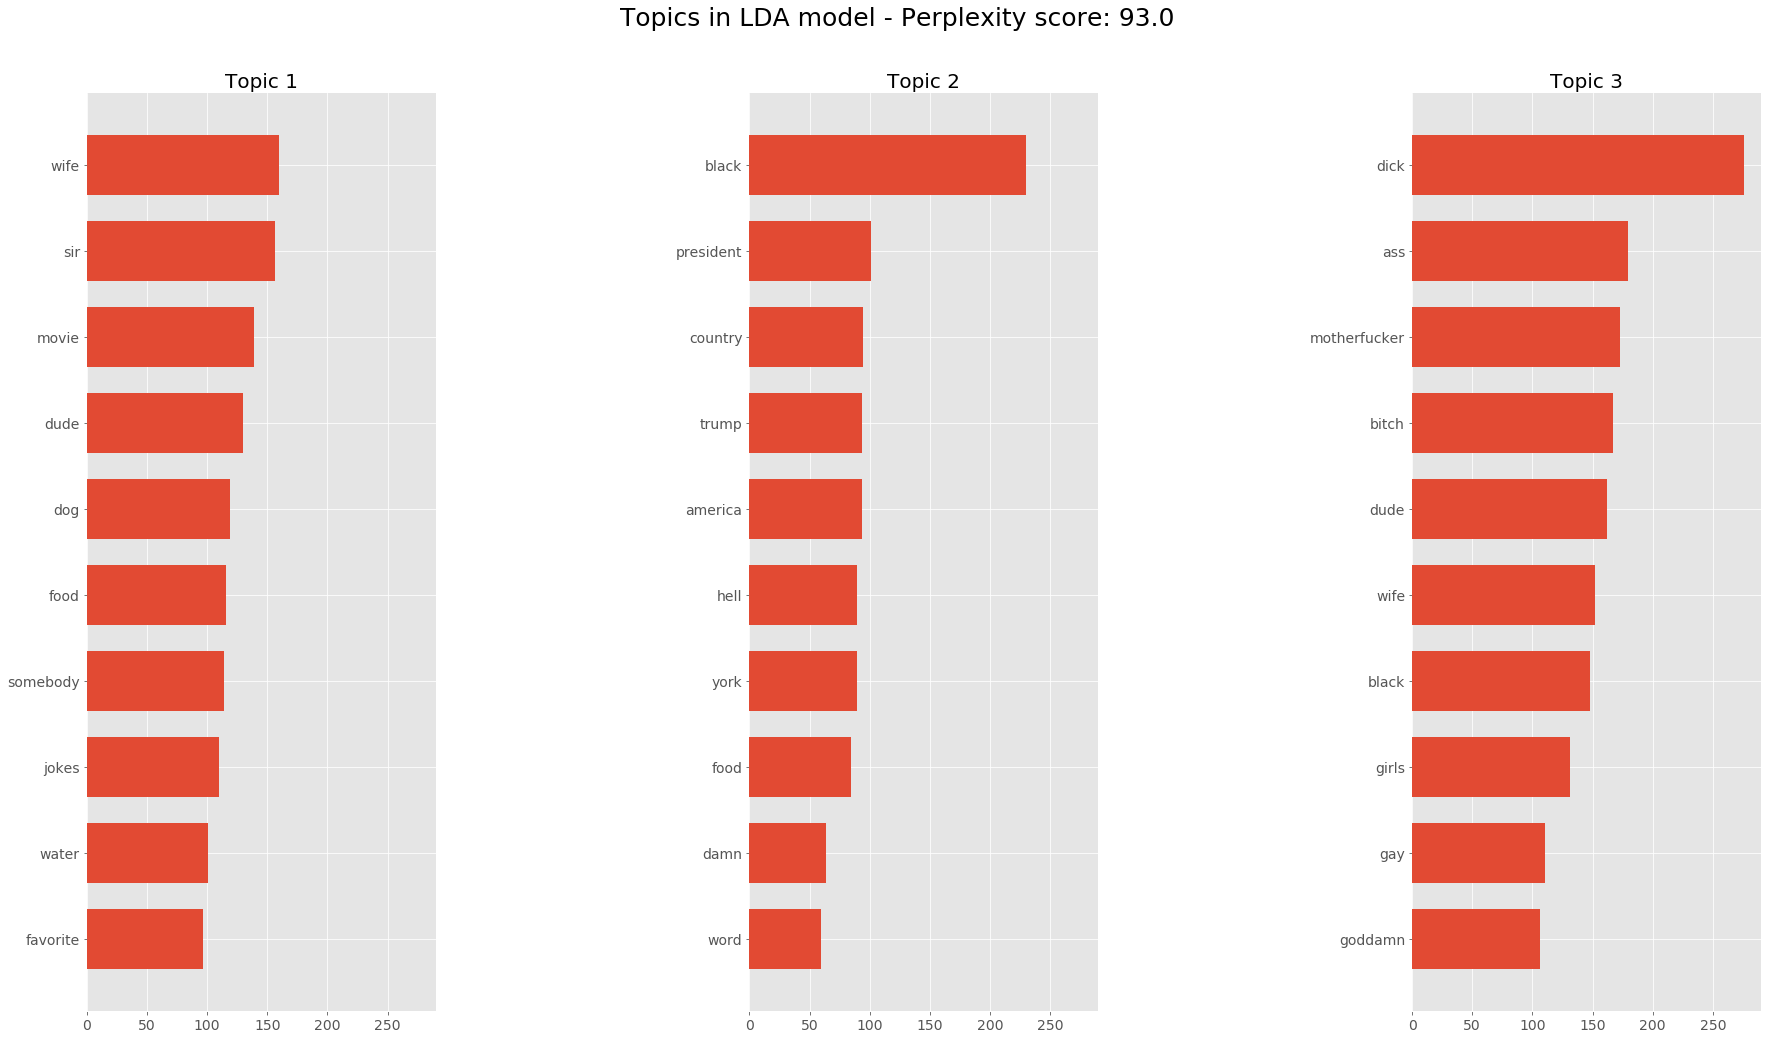

In [38]:
## Plot LDA topics

# Get tf features labels
tf_feature_names = tf_vectorizer.get_feature_names()

# Plot
plot_top_words(lda, tf, tf_feature_names, n_top_words, 'Topics in LDA model')

## 3.3) PCA and k-means on tf-IDF matrix

In this section, I have adopted a different strategy to extract and summarize the main topics discussed in stand-up comedy. This strategy involves using more "standard" machine learning techniques such as PCA (for dimensionality reduction) and K-means for clustering stand-up scripts based on their term frequency–inverse document frequency (tf-IDF) matrix. Differently from the simple tf matrix from the previous section, a value in the tf-IDF matrix acts like a weight that increases proportionally to the number of times a word appears in the document and is reduced by the number of documents in the corpus that contain the word. In this way, the value of a word is adjusted when it appears more frequently across documents compared to other more "document-specific" words.

The analysis follows these steps:
- 1) Building a term frequency–inverse document frequency (tf-IDF) vector of lenght 300 for each script in the dataset using the TfidfVectorizer from sklearn.
- 2) Exploring with Principal Component Analysis (PCA) the features space and reducing the noise in the tf-IDF matrix by selecting 80 principal components (i.e., 90% of explained variance) to pass to the k-means algorithm.
- 3) Fine-tuning the k-means algorithm using the elbow method to identify the optimal number of clusters (i.e., main topics) and visualize the most relevant 10 tokens that can summarize the content of the documents in the cluster.
- 4) Visulizing the optimal clusters idenfied with k-means and elbow method on a 2-dimensional space (using only the first 2 components from the PCA).


The optimal number of clusters identified by k-means and elbow method is 6. When looking at the top 10 tokens per cluster of documents, this time is more difficult to identify a clean and neat separation among the topics. Notice that at every run of the code the clusters can be assigned a different number as label and some "top tokens" can change do to the randomness in the k-means algorithm. For this reason, in the following description, I will refer to cluster by group of top tokens identified in the last time I run the code. 

The results that emerge from this exercise are: 
- Cluster (goddamn, trump, ass, white, black, pussy, dick, bitch, motherfucker, nigga) seems to identify with the macro-area of satire on ethnic/racial groups. On the other hand, cluster (everybody, dick, jesus, wife, movie, president, trump, black, white, dude) seems to capture satire on politicians as well as ethnic/racial groups. These two clusters closely mirror Topic 2 found in the LDA model.
- Cluster (white, mom, girls, husband, sex, baby, dick, girl, men, women) and cluster (sleep, dick, dog, phone, sex, bed, kid, dad, baby, wife) seem to both fall in the category sex/relationships. However, the latter also shows tokens that might be associated more with personal stories/anecdotes.
- The remaining clusters clearly fall in the personal stories/anecdotes category with each of them hinting towards a certain type of stories. For instance, cluster (pretty, dog, funny, friend, hate, story, dad, baby, jokes, joke) seems to summarize stand-up routines related to family-related anecdotes about daily life. On the other hand, cluster (parents, york, sir, son, kid, dude, bro, indian, dad, mom) seems to group documents where personal experiences about childhood/teenagehood are discussed.
- The mixture of different topics within each stand-up comedy script (which is what makes difficult the classification/summarization of neat topics) is well represented when the clusters are plotted in a 2 dimensional space using the first 2 components from the PCA. The final scatter plot shows that the only cluster of scripts that clearly distinguish itself from the rest are those having satire on ethnic/racial groups and politicans. The other clusters are packed into a big group with most of the variability being decribed only by differences across the PC1-axis.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

In [40]:
# Set up vectorizer to create 
tfidf = TfidfVectorizer(
    min_df = 0.05, # Ignore terms that have a doc frequency higher than this threshold
    max_df = 0.90, # Ignore terms that have a doc frequency higher than this threshold
    max_features = 300,
    stop_words = my_stop_words
)

# Dense Tf-IFD matrix to pass to PCA (dense matrix representation of the sparse matrix obtained from TfidVectorizer)
X = tfidf.fit_transform(doc_list).todense()

print('Features matrix shape:', X.shape)

Features matrix shape: (143, 300)


In [41]:
## PCA

# Create PCA transformer
pca = PCA(n_components=None)

# Apply PCA
pca.fit(X, y=None)

# Project data onto the components
X_comp = pca.transform(X)

# Proportion of variance explained
pve = pca.explained_variance_ratio_

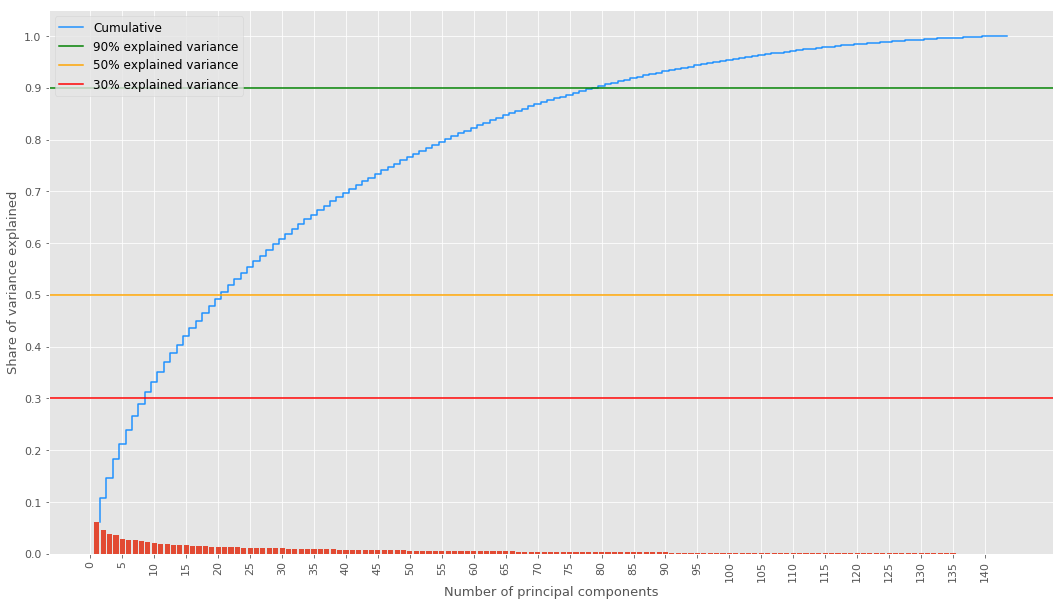

In [42]:
# Create bar plot
x_lbl = np.arange(1, len(pve) + 1) # 1,2,..,n_components
plt.figure(figsize=(18, 10))
plt.bar(x_lbl, pve)
plt.xticks(np.arange(0, len(x_lbl)+1, 5), fontsize=11, rotation=90)
plt.yticks(np.arange(0, 1.1, 0.1), fontsize=11)

# Add cumulative sum
pve_cumsum = np.cumsum(pve)
plt.step(x_lbl+0.5, pve_cumsum, label='Cumulative', color='dodgerblue')

# Add horizontal line
plt.axhline(y=0.9, color='green', label='90% explained variance')
plt.axhline(y=0.5, color='orange', label='50% explained variance')
plt.axhline(y=0.3, color='red', label='30% explained variance')

plt.xlabel('Number of principal components', fontsize=13)
plt.ylabel('Share of variance explained', fontsize=13)
plt.legend(loc='upper left', fontsize=12)
plt.show()

In [43]:
# Transfrom feature matrix to pass to k-means (retain 80 components, around 90% of variability)
pca_optimal = PCA(n_components=80)
X_k_means = pca_optimal.fit_transform(X)

print('Shape features matrix for k-means (i.e., reduced tf-IDF matrix):', X_k_means.shape)

Shape features matrix for k-means (i.e., reduced tf-IDF matrix): (143, 80)


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 21.11it/s]


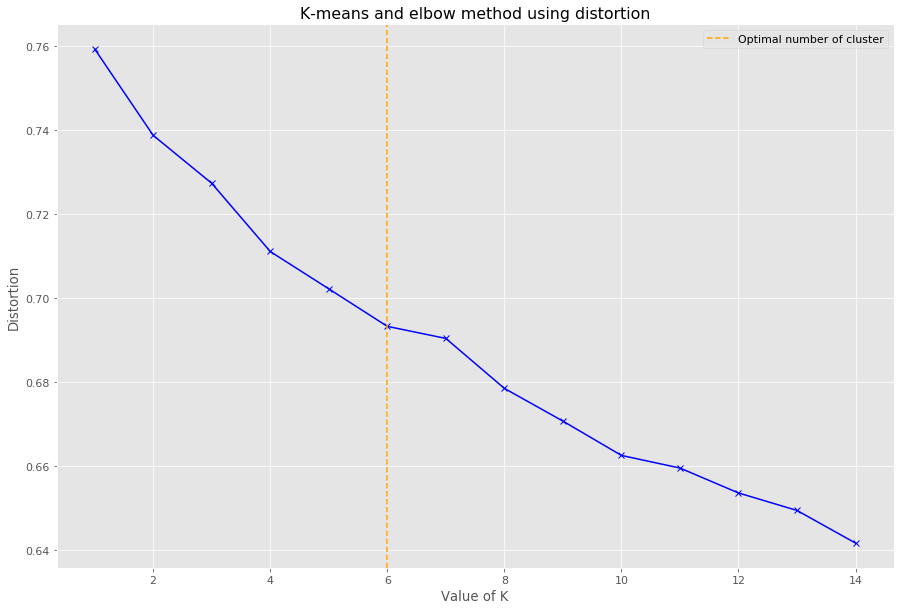

In [44]:
# Range of clusters to optimize
K = range(1, 15)

# Loop model
distortions = [] # Distortion values
inertias = [] # Inertia values

for k in tqdm(K):
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k, random_state=50)
    kmeanModel.fit(X_k_means)
 
    distortions.append(sum(np.min(cdist(X_k_means, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X_k_means.shape[0])
    inertias.append(kmeanModel.inertia_)
    

# Plot distortion vs optimal number of clusters
plt.figure(figsize=(15, 10))
plt.plot(K, distortions, 'bx-')
plt.axvline(x=6, color='orange', label='Optimal number of cluster', linestyle='--')
plt.legend()
plt.xlabel('Value of K')
plt.ylabel('Distortion')
plt.title('K-means and elbow method using distortion')
plt.show()

In [45]:
# Optimal number of clusters from Elbow method
opt_clusters = 6

# Run k-means with optimal number of clusters
optimal_kmeans = KMeans(n_clusters=opt_clusters)

# Predict the labels for each script
text_lbl = optimal_kmeans.fit_predict(X_k_means)

# Get unique labels
u_labels = np.unique(text_lbl)

In [46]:
# Define function that shows top keywords per cluster
def top_keywords(data, clusters, labels, n_terms):
    '''Print the top n-th tokens for each k-means cluster'''
    
    # Average the value of tf-IDF elements per cluster 
    df = pd.DataFrame(data).groupby(clusters).mean()
    
    # Show the words with the highest values in each cluster
    for i,r in df.iterrows():
        print('\nCluster {}:\n'.format(i))
        print(', '.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

# Apply function
top_keywords(X, text_lbl, tfidf.get_feature_names(), 10)


Cluster 0:

pretty, dog, funny, friend, hate, story, dad, baby, jokes, joke

Cluster 1:

parents, york, sir, son, kid, dude, bro, indian, dad, mom

Cluster 2:

sleep, dick, dog, phone, sex, bed, kid, dad, baby, wife

Cluster 3:

white, mom, girls, husband, sex, baby, dick, girl, men, women

Cluster 4:

goddamn, trump, ass, white, black, pussy, dick, bitch, motherfucker, nigga

Cluster 5:

everybody, dick, jesus, wife, movie, president, trump, black, white, dude


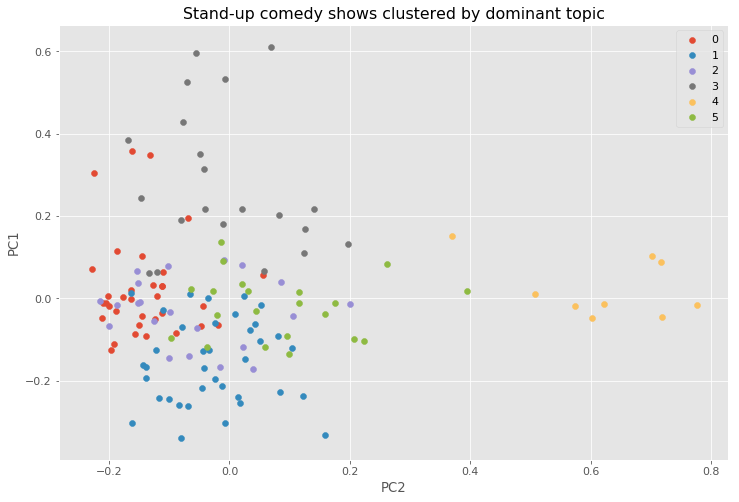

Number of documents per cluster: {1: 37, 0: 34, 5: 21, 3: 21, 2: 21, 4: 9}

Cluster 0:

pretty, dog, funny, friend, hate, story, dad, baby, jokes, joke

Cluster 1:

parents, york, sir, son, kid, dude, bro, indian, dad, mom

Cluster 2:

sleep, dick, dog, phone, sex, bed, kid, dad, baby, wife

Cluster 3:

white, mom, girls, husband, sex, baby, dick, girl, men, women

Cluster 4:

goddamn, trump, ass, white, black, pussy, dick, bitch, motherfucker, nigga

Cluster 5:

everybody, dick, jesus, wife, movie, president, trump, black, white, dude


In [47]:
## Representation of stand-up comedy clusters

# Reduce dimensionality to represent clusters in scatterplot
pca_chart = PCA(n_components=2)

X_reduced = pca_chart.fit_transform(X)

 
# Plot
plt.figure(figsize=(12, 8))
for i in u_labels:
    plt.scatter(X_reduced[text_lbl==i , 0] , X_reduced[text_lbl==i , 1] , label= i)
plt.legend()
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.title('Stand-up comedy shows clustered by dominant topic')

plt.show()


# Identify number of documents per cluster
cluster_lbl = list(pd.Series(text_lbl).value_counts().index)
cluster_num = list(pd.Series(text_lbl).value_counts().values)
cluster_desc = dict(zip(cluster_lbl, cluster_num))
print('Number of documents per cluster:', cluster_desc)

# Add cluster keywords
top_keywords(X, text_lbl, tfidf.get_feature_names(), 10)